# Virtual Pets
**Jin Yeom**  
jin.yeom@hudl.com

In this notebook, we create a prototype for a virtual pet game, similar to existing virtual pet toys like [Digimon](https://en.wikipedia.org/wiki/Digimon) and [Tamagochi](https://en.wikipedia.org/wiki/Tamagotchi). This project is also inspired by [this tweet](https://twitter.com/lexaloffle/status/1129071867610853376). Most importantly, however, we aim to create such a game that is a bit more intelligent, by applying more advanced techniques for generating sprites and their behaviours.

## Motivation

A "tweetcart" for Pico-8 by @lexaloffle:

```lua
function rnd_spr(r,x,y)
srand(r)pal(1,13)pal(2,7)
for v=0,7 do for u=0,3 do
c=rnd(3) pset(x+u,y+v,c) pset(x+7-u,y+v,c)
end end end

cls()p=0::_::
for y=0,11 do for x=0,11 do
rnd_spr(p*144+x+y*12,4+x*10,4+y*10)
end end if(btnp(5))p+=1 goto _
```

<img src="images/example.png" align=left width=30%></img>

Let's start by taking a better look at the random sprite generation algorithm in the tweet:

```lua
function rnd_spr(r,x,y)
    -- Seed the random number generator.
    srand(r)
    
    -- `pal` seems to be specific to Pico-8.
    --
    -- According to https://pico-8.fandom.com/wiki/Pal:
    --   "Changes the draw state so all instances of a 
    --   given color are replaced with a new color."
    pal(1,13)
    pal(2,7) 
    
    for v=0,7 do 
        for u=0,3 do
            -- Simply assigning random colors,
            -- but with vertical symmetry.
            c=rnd(3) 
            pset(x+u,y+v,c) 
            pset(x+7-u,y+v,c)
        end 
    end 
end

cls()
p = 0
::_::
for y=0,11 do 
    for x=0,11 do
        rnd_spr(p*144+x+y*12,4+x*10,4+y*10)
    end
end

-- When button "5" is pressed, increment `p` by 1 and
-- iterate from `_` again.
--
-- Since this seems irrelevant for us, we'll ignore it.
if(btnp(5)) 
    p+=1
    goto _
```

In [1]:
from enum import Enum

In [2]:
import numpy as np
from matplotlib import pyplot as plt

Let's try reimplementing the algorithm above in Python!

In [3]:
class Color(Enum):
    WHITE = (255, 255, 255)
    GREY = (128, 128, 128)
    BLACK = (0, 0, 0)
    
    @classmethod
    def rand(cls, rng=None):
        options = ['WHITE', 'GREY', 'BLACK']
        if rng is None:
            return cls[np.random.choice(options)]
        return cls[rng.choice(options)]

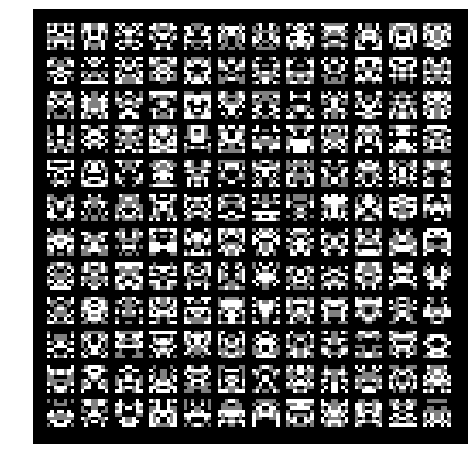

In [4]:
def rnd_spr(s, r, x, y):
    rng = np.random.RandomState(r)
    for v in range(8):
        for u in range(4):
            c = Color.rand(rng)
            s[y+v, x+u, :] = c.value
            s[y+v, x+7-u, :] = c.value

plt.figure(figsize=(8, 8))
plt.axis('off')
s = np.zeros((127, 127, 3), dtype=np.uint8)
for y in range(12):
    for x in range(12):
        rnd_spr(s,x+y*12,4+x*10,4+y*10)
plt.imshow(s)
plt.show()

Once again, I'd like to mention how uncanny it is that these look like they can be some creatures, just because they're symmetrical.

In [5]:
def rnd_spr(r=None, s=10):
    rng = np.random.RandomState(r)
    spr = np.zeros((s, s, 3), np.uint8)
    for v in range(s-2):
        for u in range((s-2)//2):
            c = Color.rand(rng)
            spr[v+1, u+1, :] = c.value
            spr[v+1, s-2-u, :] = c.value
    return spr

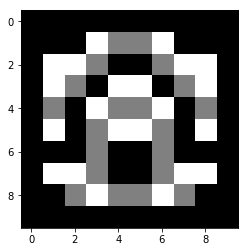

In [6]:
spr = rnd_spr()
plt.imshow(spr)
plt.show()

## Compositional Pattern Producing Networks

In [24]:
class Node:
    _activ_fns = {
        'sigmoid': lambda x: 1 / 1 + np.exp(-x),
        'tanh': lambda x: np.tanh(x),
        'relu': lambda x: x * (x > 0),
        'cos': lambda x: np.cos(x),
        'gaussian': lambda x: np.exp(-0.5*x**2)/np.sqrt(2*np.pi),
    }
    
    def __init__(self, activ_fn=None):
        self.activ_fn = activ_fn
        self.connections = {}
        self.activation = 0.0
    
    def __str__(self):
        return f'Node({self.activ_fn}, {len(self.connections)})'
        
    @staticmethod
    def rand_activ_fn(rng=None):
        options = list(Node._activ_fns.keys())
        if rng is None:
            return np.random.choice(options)
        return rng.choice(options)
    
    def connect_from(self, node, weight):
        self.connections[node] = weight
        
    def activate(self):
        if len(self.connections):
            z = sum(w * n.activation for n, w in self.connections.items())
            if self.activ_nf is not None:
                z = Node._activ_fns[self.activ_fn](z)
            self.activation = z

In [30]:
class CPPN:
    def __init__(self, n_in, n_out, seed):
        self.n_in = n_in
        self.n_out = n_out
        self._rng = np.random.RandomState(seed)
        self.input_nodes = [Node() for _ in range(n_in)]
        self.hidden_nodes = []  # will be added through mutation
        self.output_nodes = [Node() for _ in range(n_out)]
        self.size = n_in + n_out
        
    @property
    def nodes(self):
        return self.input_nodes + self.hidden_nodes + self.output_nodes
        
    def perturb(self):
        node = self._rng.choice(self.nodes[self.n_in:])
        src = self._rng.choice(list(node.connections.keys()))
        node.connections[src] += self._rng.normal(loc=0.0, scale=1e-2)
        
    def _rand_node(self):
        activ_fn = Node.rand_activ_fn(rng=self._rng)
        return Node(activ_fn=activ_fn)
    
    def _rand_weight(self):
        return self._rng.normal(loc=0.0, scale=1e-2)
        
    def add_conn(self):
        dst = self._rng.randint(self.n_in, self.size)
        dst_node = self.nodes[dst]
        conns = set(dst_node.connections.keys())
        lim = min(dst, self.size - self.n_out)  # source node limit
        src_cands = [n for n in self.nodes[:lim] if n not in conns]
        if len(src_cands):
            src_node = self._rng.choice(src_cands)
            weight = self._rand_weight()
            dst_node.connect_from(src_node, weight)
        
    def add_node(self):
        pos = 0
        if len(self.hidden_nodes):
            pos = self._rng.randint(0, len(self.hidden_nodes))
        new = self._rand_node()
        self.hidden_nodes.insert(pos, new)
        src = self._rng.choice(self.input_nodes+self.hidden_nodes[:pos])
        dst = self._rng.choice(self.hidden_nodes[pos+1:] + self.output_nodes)
        new.connect_from(src, self._rand_weight())
        dst.connect_from(new, self._rand_weight())
        
    def activate(self, x):
        raise NotImplementedError